In [ ]:
# 2. Mount Google Drive to access your data
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- CELL 1: Data Consolidation and Setup ---
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split # Still import, but we won't use it now
import matplotlib.pyplot as plt

# 1. Define Fixed Scaling Limits (CRUCIAL for ESP32 Deployment)
PWM_MIN, PWM_MAX = 0.0, 8192.0
RPM_MIN, RPM_MAX = 0.0, 635.0
PWM_RANGE = PWM_MAX - PWM_MIN
RPM_RANGE = RPM_MAX - RPM_MIN

# 2. Define File Paths and Load DataFrames
# !!! VERIFY THESE PATHS MATCH YOUR DRIVE STRUCTURE !!!
path_sine_rhythmic = '/content/drive/MyDrive/motor dataset/sine_changing_offset.csv'
path_step_down = '/content/drive/MyDrive/motor dataset/step_down.csv' # Assuming you named it this

df_sine = pd.read_csv(path_sine_rhythmic)
df_step_down = pd.read_csv(path_step_down)

# 3. Standardize Column Names Across All DataFrames
# The name of the timestamp column varies, so we standardize the others first.
rename_map = {
    'RPM': 'omega_act',
    'Setpoint': 'omega_des',
    'PWMPrev': 'u_total_last_raw',
    'PWM': 'u_total'
}

df_sine.rename(columns=rename_map, inplace=True)
df_step_down.rename(columns=rename_map, inplace=True)

# 4. CONSOLIDATE DATA: Create the Final Training Set
df_train_final = pd.concat([df_sine, df_step_down], ignore_index=True)

# 5. Define the Input Features and Target
INPUT_FEATURES = ['omega_des', 'omega_act', 'u_total_last_raw']
TARGET_FEATURE = 'u_total'

# Load final data arrays
X_data = df_train_final[INPUT_FEATURES].values.astype(np.float32)
Y_data = df_train_final[TARGET_FEATURE].values.reshape(-1, 1).astype(np.float32)

# DEBUG CHECK: Check for NaNs and Infs after consolidation
print(f"Total Consolidated Samples: {X_data.shape[0]}")
print(f"NaN count after consolidation: \n{df_train_final.isnull().sum()}")
df_train_final.dropna(inplace=True)

# Re-run X/Y assignment after dropping NaNs, if any were found
X_data = df_train_final[INPUT_FEATURES].values.astype(np.float32)
Y_data = df_train_final[TARGET_FEATURE].values.reshape(-1, 1).astype(np.float32)
print(f"Final Samples for Training: {X_data.shape[0]}")

Total Consolidated Samples: 72301
NaN count after consolidation: 
Timestamp           8
omega_act           8
omega_des           8
Error               0
u_total_last_raw    0
u_total             8
dtype: int64
Final Samples for Training: 72293


In [ ]:
# --- CELL 2: Data Preprocessing (Normalization Only) ---

# Custom Normalization Function
def normalize_data(data, data_min, data_range):
    """ Scales data to the range [0, 1] using fixed physical limits. """
    return (data - data_min) / data_range

# 1. Prepare Input (X) Data - Scales inputs according to their type (RPM or PWM)
X_data_scaled = np.zeros_like(X_data, dtype=np.float32)

# Input 1: Desired RPM (Index 0 - omega_des) -> Scale by RPM_RANGE
X_data_scaled[:, 0] = normalize_data(X_data[:, 0], RPM_MIN, RPM_RANGE)

# Input 2: Actual RPM (Index 1 - omega_act) -> Scale by RPM_RANGE
X_data_scaled[:, 1] = normalize_data(X_data[:, 1], RPM_MIN, RPM_RANGE)

# Input 3: Last Total PWM (Index 2 - u_total_last_raw) -> Scale by PWM_RANGE
X_data_scaled[:, 2] = normalize_data(X_data[:, 2], PWM_MIN, PWM_RANGE)


# 2. Prepare Target (Y) Data - Scales the current total PWM output
Y_data_scaled = normalize_data(Y_data.flatten(), PWM_MIN, PWM_RANGE).reshape(-1, 1)


# 3. Assign All Data to Training (Validation will be external)
X_train = X_data_scaled
Y_train = Y_data_scaled

print(f"All {X_train.shape[0]} samples assigned to Training Set.")

All 72293 samples assigned to Training Set.


In [ ]:
# 1. Hyperparameters
INPUT_DIM = X_train.shape[1] # Should be 3
HIDDEN_UNITS = 20
# NOTE: We can reduce EPOCHS now that we don't rely on Early Stopping
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# 2. Define the Model Architecture (MLP) - Architecture remains perfect
model = keras.Sequential([
    # Hidden Layer 1
    keras.layers.Dense(HIDDEN_UNITS, activation='relu', input_shape=(INPUT_DIM,)),

    # Hidden Layer 2
    keras.layers.Dense(HIDDEN_UNITS, activation='relu'),

    # Output Layer: Linear activation (scaled 0-1 PWM)
    keras.layers.Dense(1, activation='linear')
])

# 3. Compile the Model (No Change)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

model.summary()

# 4. Train the Model (Removed internal validation and Early Stopping)
# The model will train on the entire consolidated dataset for 100 epochs.

history = model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    # validation_data=... REMOVED
    # callbacks=[...] REMOVED
    verbose=1
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 20)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521 (2.04 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0065 - mae: 0.0304
Epoch 2/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.4178e-05 - mae: 0.0033
Epoch 3/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.4751e-05 - mae: 0.0035
Epoch 4/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.4085e-05 - mae: 0.0036
Epoch 5/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.6374e-05 - mae: 0.0036
Epoch 6/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.0445e-05 - mae: 0.0036
Epoch 7/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.1464e-05 - mae: 0.0035
Epoch 8/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.2410e-05 - mae: 0.0037
Epoch 9/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.0370e-05 - mae: 0.0035
Epoch 10/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.6367e-05 - mae: 0.0034
Epoch 11/100
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.0217e-05 - mae: 0.0036
Epoch 12/100
2260/2260 ━━━━━━━━━━━


--- Validation Check 2: Step Up Data (Sharp Acceleration) ---
Test MAE (Normalized): 0.007401
Test MAE (Raw PWM Units): 60.63


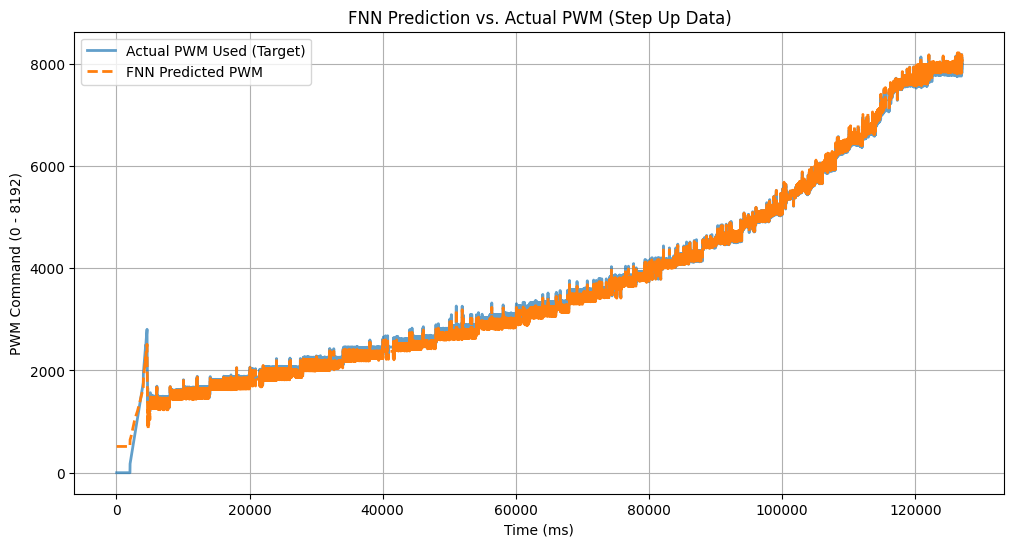

In [ ]:
# --- CELL 5: Validation on STEP UP Data ---

# 1. Define the path to your Step Up Test Data
# !!! CHANGE THIS PATH !!!
step_up_data_path = '/content/drive/MyDrive/motor dataset/step.csv'
df_val_step = pd.read_csv(step_up_data_path)

# 2. Standardize Column Names (Assuming you successfully cleaned the CSV)
df_val_step.rename(columns={
    'Timestamp': 'timestamp',
    'RPM': 'omega_act',
    'Setpoint': 'omega_des',
    'PWMPrev': 'u_total_last_raw',
    'PWM': 'u_total_target'
}, inplace=True)

# 3. Define test input data (must be float32)
X_step_raw = df_val_step[['omega_des', 'omega_act', 'u_total_last_raw']].values.astype(np.float32)
Y_step_raw_target = df_val_step['u_total_target'].values.reshape(-1, 1).astype(np.float32)

# 4. Normalize the Step Test Data
X_step_scaled = np.zeros_like(X_step_raw, dtype=np.float32)

# Scale RPM inputs
X_step_scaled[:, 0] = normalize_data(X_step_raw[:, 0], RPM_MIN, RPM_RANGE)
X_step_scaled[:, 1] = normalize_data(X_step_raw[:, 1], RPM_MIN, RPM_RANGE)
X_step_scaled[:, 2] = normalize_data(X_step_raw[:, 2], PWM_MIN, PWM_RANGE)

Y_step_scaled_target = normalize_data(Y_step_raw_target.flatten(), PWM_MIN, PWM_RANGE).reshape(-1, 1)


# 5. Predict PWM using the Trained Model and De-Normalize
Y_step_scaled_predicted = model.predict(X_step_scaled, verbose=0)
Y_step_raw_predicted = unscale_data(Y_step_scaled_predicted, PWM_MIN, PWM_RANGE)


# 6. Evaluate Performance
loss, mae = model.evaluate(X_step_scaled, Y_step_scaled_target, verbose=0)
raw_pwm_mae = mae * PWM_RANGE

print("\n--- Validation Check 2: Step Up Data (Sharp Acceleration) ---")
print(f"Test MAE (Normalized): {mae:.6f}")
print(f"Test MAE (Raw PWM Units): {raw_pwm_mae:.2f}")


# 7. Visualize the Tracking Performance (PWM)
plt.figure(figsize=(12, 6))
plt.plot(df_val_step['timestamp'], Y_step_raw_target, label='Actual PWM Used (Target)', alpha=0.7, linewidth=2)
plt.plot(df_val_step['timestamp'], Y_step_raw_predicted, label='FNN Predicted PWM', linestyle='--', alpha=1.0, linewidth=2)

plt.title('FNN Prediction vs. Actual PWM (Step Up Data)')
plt.xlabel('Time (ms)')
plt.ylabel('PWM Command (0 - 8192)')
plt.legend()
plt.grid(True)
plt.show()


--- Data Quality Check: Unseen Sine Wave ---
NaN count before cleaning: 
timestamp           1
omega_act           1
omega_des           1
Error               0
u_total_last_raw    0
u_total_target      1
dtype: int64
Total Samples after cleaning: 11418
--- End of Check ---

--- Validation Check 1: Unseen Sine Wave (Continuous Tracking) ---
Test MAE (Normalized): 0.006206
Test MAE (Raw PWM Units): 50.84


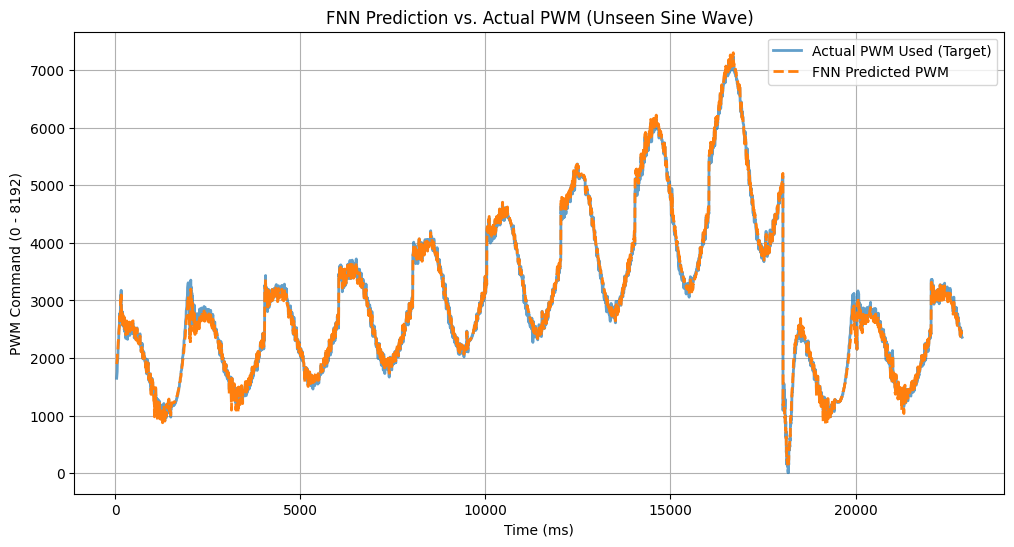

In [ ]:
# --- CELL 4: Validation on UNSEEN Sine Wave Data (DIAGNOSTIC CHECK) ---

# 1. Define the path to your new Sine Wave Validation Data
sine_val_data_path = '/content/drive/MyDrive/motor dataset/sine_changing_offset_periodic.csv'
df_val_sine = pd.read_csv(sine_val_data_path)

# 2. Standardize Column Names
# Assuming you successfully cleaned the column names in the CSV file manually:
df_val_sine.rename(columns={
    'Timestamp': 'timestamp',
    'RPM': 'omega_act',
    'Setpoint': 'omega_des',
    'PWMPrev': 'u_total_last_raw',
    'PWM': 'u_total_target'
}, inplace=True)

# 3. CRITICAL DEBUGGING CHECKS
print("\n--- Data Quality Check: Unseen Sine Wave ---")
# Check for explicit NaNs
print(f"NaN count before cleaning: \n{df_val_sine.isnull().sum()}")
if df_val_sine.isnull().values.any():
    print("WARNING: NaNs found. Dropping rows with any NaN values.")
    df_val_sine.dropna(inplace=True)

# Define test input data (must be float32)
X_sine_raw = df_val_sine[['omega_des', 'omega_act', 'u_total_last_raw']].values.astype(np.float32)
Y_sine_raw_target = df_val_sine['u_total_target'].values.reshape(-1, 1).astype(np.float32)

# Check for Infinite Values (Infs)
if np.isinf(X_sine_raw).any():
    print("CRITICAL ERROR: Infinite values detected in raw X data!")
    # Filter out or replace Infs if possible
    X_sine_raw[np.isinf(X_sine_raw)] = np.nan
    df_val_sine = df_val_sine[~np.isinf(X_sine_raw).any(axis=1)]

# Final check before normalization
print(f"Total Samples after cleaning: {X_sine_raw.shape[0]}")
print("--- End of Check ---")


# 4. Normalize the Sine Test Data using the fixed global limits (RPM_MIN/MAX, PWM_MIN/MAX)
X_sine_scaled = np.zeros_like(X_sine_raw, dtype=np.float32)

# Scale RPM inputs
X_sine_scaled[:, 0] = normalize_data(X_sine_raw[:, 0], RPM_MIN, RPM_RANGE)
X_sine_scaled[:, 1] = normalize_data(X_sine_raw[:, 1], RPM_MIN, RPM_RANGE)

# Scale PWM input
X_sine_scaled[:, 2] = normalize_data(X_sine_raw[:, 2], PWM_MIN, PWM_RANGE)

Y_sine_scaled_target = normalize_data(Y_sine_raw_target.flatten(), PWM_MIN, PWM_RANGE).reshape(-1, 1)


# 5. Predict PWM using the Trained Model and De-Normalize
# The verbose=0 hides the progress bar, preventing potential issues during debug
Y_sine_scaled_predicted = model.predict(X_sine_scaled, verbose=0)


# 6. Evaluate Performance (If prediction was NaN, evaluation will also be NaN)
loss, mae = model.evaluate(X_sine_scaled, Y_sine_scaled_target, verbose=0)
raw_pwm_mae = mae * PWM_RANGE

print("\n--- Validation Check 1: Unseen Sine Wave (Continuous Tracking) ---")
print(f"Test MAE (Normalized): {mae:.6f}")
print(f"Test MAE (Raw PWM Units): {raw_pwm_mae:.2f}")


# 7. Visualize (Only if MAE is not NaN)
if not np.isnan(mae):
    Y_sine_raw_predicted = unscale_data(Y_sine_scaled_predicted, PWM_MIN, PWM_RANGE)

    plt.figure(figsize=(12, 6))
    plt.plot(df_val_sine['timestamp'], Y_sine_raw_target, label='Actual PWM Used (Target)', alpha=0.7, linewidth=2)
    plt.plot(df_val_sine['timestamp'], Y_sine_raw_predicted, label='FNN Predicted PWM', linestyle='--', alpha=1.0, linewidth=2)
    plt.title('FNN Prediction vs. Actual PWM (Unseen Sine Wave)')
    plt.xlabel('Time (ms)')
    plt.ylabel('PWM Command (0 - 8192)')
    plt.legend()
    plt.grid(True)
    plt.show()

# If the error is not resolved, the problem may be that one of the RPM or PWM values
# in the CSV is outside the fixed limits (RPM_MAX=635, PWM_MAX=8192).
# This would cause the normalization to create values far outside the [0, 1] range,
# leading to the NaN error.

In [ ]:
# --- STEP 1: Ensure Model is Saved to the Correct Location ---
# This assumes you have already run Cell 3 and the 'model' object is in memory!

import os
from tensorflow import keras

# Define the BASE FOLDER where the model should be saved
base_folder = '/content/drive/MyDrive/motor dataset/'
model_file_name = 'motor_nn_controller_final.h5'
model_save_path = os.path.join(base_folder, model_file_name)

# Ensure the folder exists (it should, being your Drive folder)
if not os.path.exists(base_folder):
    os.makedirs(base_folder)

# --- SAVE THE MODEL HERE ---
# This creates the .h5 file that the next block needs.
model.save(model_save_path)

print(f"Model saved successfully to: {model_save_path}")
print("Ready to proceed to Step 2: Extracting Weights.")

Model saved successfully to: /content/drive/MyDrive/motor dataset/motor_nn_controller_final.h5
Ready to proceed to Step 2: Extracting Weights.


In [ ]:
# --- CELL 6: Keras Model to C++ Header File Generator (FINAL RUN - CUSTOM OBJECTS FIX) ---
import numpy as np
import os
from tensorflow import keras

# Import the necessary standard loss and metric functions
import keras.losses
import keras.metrics

# 1. Define the BASE FOLDER and FILE PATH
base_folder = '/content/drive/MyDrive/motor dataset/'
model_file_name = 'motor_nn_controller_final.h5'
model_save_path = os.path.join(base_folder, model_file_name)

# Load the Saved Model using custom_objects to prevent the TypeError
# We explicitly tell Keras where to find 'mse' and 'mae'
model = keras.models.load_model(
    model_save_path,
    custom_objects={
        'mse': keras.losses.mean_squared_error,
        'mae': keras.metrics.mean_absolute_error,
    }
)

# 2. Define File Paths for C++ Output
output_file_name = 'motor_nn_weights.h'
output_header_path = os.path.join(base_folder, output_file_name)
header_file = open(output_header_path, 'w')

# 3. Write C++ Header Guard and Includes
header_file.write('#ifndef MOTOR_NN_WEIGHTS_H\n')
header_file.write('#define MOTOR_NN_WEIGHTS_H\n\n')
header_file.write('#include <math.h>\n\n')
header_file.write('// FNN Architecture: 3 inputs -> 20 nodes -> 20 nodes -> 1 output\n')
header_file.write('// Total Parameters: 521\n\n')

# 4. Extract and Format Weights/Biases (The extraction logic is unchanged)
layer_index = 0
for layer in model.layers:
    if isinstance(layer, keras.layers.Dense):
        layer_index += 1
        weights, biases = layer.get_weights()

        # --- A. Weights Array ---
        weights_shape = weights.shape
        var_name = f'w{layer_index}_weights'

        header_file.write(f'// Weights for Layer {layer_index}: Shape {weights_shape}\n')
        header_file.write(f'const float {var_name}[{weights_shape[0]}][{weights_shape[1]}] = {{\n')

        for i in range(weights_shape[0]):
            header_file.write('  {')
            values = [f'{w:.6f}f' for w in weights[i]]
            header_file.write(', '.join(values))
            header_file.write('}')
            if i < weights_shape[0] - 1:
                header_file.write(',\n')
            else:
                header_file.write('\n')
        header_file.write('};\n\n')

        # --- B. Biases Array ---
        biases_shape = biases.shape
        var_name = f'b{layer_index}_biases'

        header_file.write(f'// Biases for Layer {layer_index}: Shape {biases_shape}\n')
        header_file.write(f'const float {var_name}[{biases_shape[0]}] = {{\n')

        values = [f'{b:.6f}f' for b in biases]
        header_file.write('  ' + ', '.join(values) + '\n')
        header_file.write('};\n\n')

# 5. Write Closing Guard
header_file.write('#endif // MOTOR_NN_WEIGHTS_H\n')
header_file.close()

print(f"Successfully loaded model from: {model_save_path}")
print(f"Successfully exported {layer_index} layers to: {output_header_path}")
print("Your C++ weights header file is ready!")

Successfully loaded model from: /content/drive/MyDrive/motor dataset/motor_nn_controller_final.h5
Successfully exported 3 layers to: /content/drive/MyDrive/motor dataset/motor_nn_weights.h
Your C++ weights header file is ready!
